# Introduction



The data from the World Health Organization shows that about 1.3 million people die of traffic collisions and about 20 to 50 million people injured every year. Road traffic collision is one of the largest public health problems in the US. To more effectively improve road safety, it is necessary to study the vulnerability of different groups to crashes, and give more protection to the vulnerable groups. This dataset has sufficient data for us to predict different types of causes resulting in car collisions, helping us to identify the most vulnerable groups and the key factors that lead to a traffic collision. Additionally, Covid-19 has a significant impact on people’s daily lives and travel behavior. We’d like to explore if covid-19 changes the traffic collision and the trend of collision cases changes during the pandemic.

In this project, we’re trying to study what kinds of people are more likely to engage in heavy traffic
collisions, what kind of people are more vulnerable to traffic collisions, and whether the covid
influences traffic behavior based on the number of traffic collisions. We also hope to conclude
with a good model to predict the survival of traffic collisions in California.

# Set Up

In [ ]:
!pip install pandasql
!pip install googledrivedownloader

import pandas as pd
import pandasql as ps 
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import sqlite3

  Created wheel for pandasql: filename=pandasql-0.7.3-cp37-none-any.whl size=26820 sha256=370bbc6dbd7f6c656b42ec22288179b966d0a814b070f879a32c3e86659e2140
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [ ]:
!pip install torch torchvision
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Wrangling

Import Data

In [ ]:

!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"tingtinghuang","key":"aac13d0ca79d32c231ff4366d89fa3df"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d alexgude/california-traffic-collision-data-from-switrs -p /content

100% 1.24G/1.24G [00:24<00:00, 39.9MB/s]
100% 1.24G/1.24G [00:24<00:00, 54.8MB/s]


In [ ]:
!unzip \*.zip

Archive:  california-traffic-collision-data-from-switrs.zip
  inflating: switrs.sqlite           


The dataset has three tables: collisions, parties and victims. The explanation for the dataset can be seen here: https://tims.berkeley.edu/help/SWITRS.php

First, we import the dataset and save it in dataframe. We use data from 2018 to 2020 for this project. 

---



In [ ]:
with sqlite3.connect('/content/switrs.sqlite') as con:
  query_collisions = ("Select * from collisions where latitude is not null and longitude is not null and date(collision_date) between date('2018-01-01') and date('2020-12-31')")
  df_collisions = pd.read_sql_query(query_collisions,con) 

In [ ]:
with sqlite3.connect('/content/switrs.sqlite') as con:
   query_parties = ("Select case_id, party_number,party_age as age, party_sex as sex, party_sobriety, party_drug_physical from parties where case_id>8200000 and case_id < 9200000")
   df_parties = pd.read_sql_query(query_parties,con)
   query_victims = ("Select case_id,party_number, victim_role, victim_age as age,victim_sex as sex,victim_degree_of_injury as injury,victim_seating_position as seating_position,victim_safety_equipment_1 as safety_equipment from victims where case_id>8200000 and case_id < 9200000")
   df_victims = pd.read_sql_query(query_victims,con)  


Clean the data of parties. We combine similar sobriety and drug physical conditions into the same category. For the sobriety, we can combine to drinking, not drinking and unknown categories. For the drug physical condition, we can combine to have problem, unknown and none(not have problem) categories.

In [ ]:
df_parties.dropna()
df_parties = df_parties.loc[(df_parties['age']>=0)&(df_parties['age']<=100)]
df_parties['party_sobriety']=df_parties['party_sobriety'].replace(['A'],'Not Drinking')
df_parties['party_sobriety']=df_parties['party_sobriety'].replace(['B','C','D'],'Drinking')
df_parties['party_sobriety']=df_parties['party_sobriety'].replace(['G','H'],'Unknown')
df_parties['party_drug_physical']=df_parties['party_drug_physical'].replace(['E','F','I'],'Have drug or physical problem')
df_parties['party_drug_physical']=df_parties['party_drug_physical'].replace(['G','H'],'Unknown')
df_parties = df_parties[df_parties.sex != 'X']

Clean the data of victims.

For the injury, there are 8 conditions in the dataset:

1 - Killed. 
2 - Severe Injury. 
3 - Other Visible Injury. 
4 - Complaint of Pain.

5 - Suspected Serious Injury.
6 - Suspected Minor Injury.
7 - Possible Injury.
0 - No Injury.

We combine 2 and 5 as severe injury; 3,4,6 and 7 as minor injury.



For the safety_equipment, there are several conditions in the dataset, we combine them into 4 types: 

A.None in Vechicle

B.Unknown

C.Use Safety Equipment 

D.Not Use Safety Equipment

In [ ]:
df_victims.dropna()
df_victims['injury'].replace(['suspected serious injury','other visible injury','complaint of pain','suspected minor injury','possible injury'], ['severe injury','minor injury','minor injury','minor injury','minor injury'], inplace = True) 
df_victims['safety_equipment']=df_victims['safety_equipment'].replace(['C','E','G','J','L','P','Q','W','Y'],'Use Safety Equipment')
df_victims['safety_equipment']=df_victims['safety_equipment'].replace(['B','N','S'],'Unknown')
df_victims['safety_equipment']=df_victims['safety_equipment'].replace(['A','U'],'None in Vechicle')
df_victims['safety_equipment']=df_victims['safety_equipment'].replace(['D','F','H','K','M','R','T','V','X'],'Not Use Safety Equipment')
df_victims = df_victims.drop(df_victims[df_victims['age']>100].index)
df_victims = df_victims.drop(df_victims[(df_victims.injury != 'killed') & (df_victims.injury != 'severe injury')& (df_victims.injury != 'minor injury')& (df_victims.injury != 'no injury')].index)
df_victims = df_victims.drop(df_victims[(df_victims.sex != 'male') & (df_victims.sex != 'female')].index)
df_victims

,case_id,party_number,victim_role,age,sex,injury,seating_position,safety_equipment
0,8200001,1,1,46.0,female,minor injury,1,Not Use Safety Equipment
1,8200002,2,3,52.0,female,minor injury,9,None
2,8200003,2,2,3.0,female,no injury,4,Not Use Safety Equipment
3,8200003,2,2,NaN,female,no injury,5,Not Use Safety Equipment
4,8200003,3,2,26.0,female,no injury,3,Not Use Safety Equipment
...,...,...,...,...,...,...,...,...
1639550,90326285,1,2,19.0,female,severe injury,4,Use Safety Equipment
1639551,90326285,1,2,21.0,male,killed,6,Use Safety Equipment
1639552,90326285,1,2,22.0,male,severe injury,3,Not Use Safety Equipment
1639553,90219813,2,2,15.0,female,minor injury,4,Use Safety Equipment


# Exploratory Data Analysis

Show the victims age and injury severity.

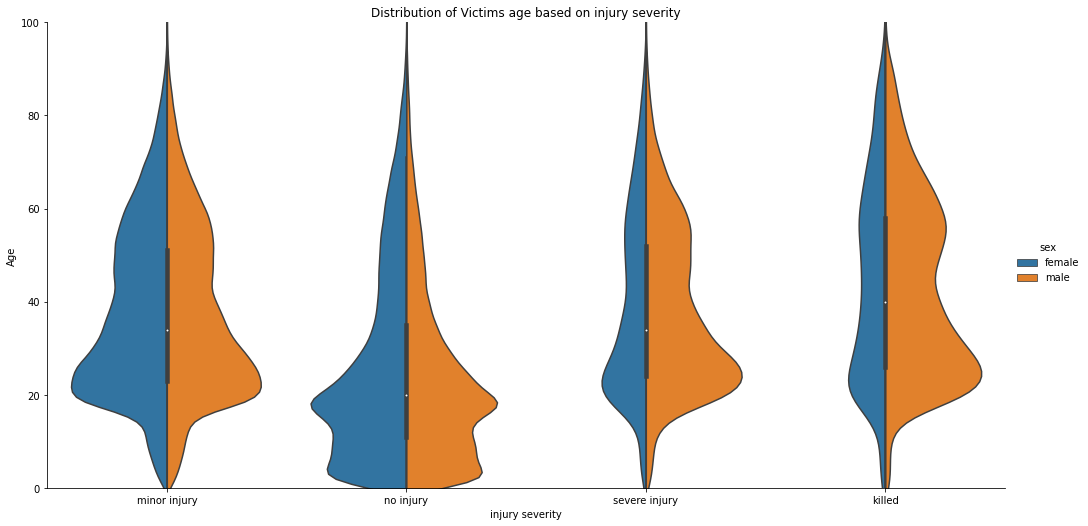

In [ ]:
ax = sns.catplot(x="injury", y="age",  kind="violin",hue="sex", scale="count",data=df_victims, height=7, aspect=2,split=True)
plt.title('Distribution of Victims age based on injury severity')
ax.set(xlabel="injury severity", ylabel = "Age")
ax.set(ylim=(0, 100))

Show the victims age based on drinking condition.

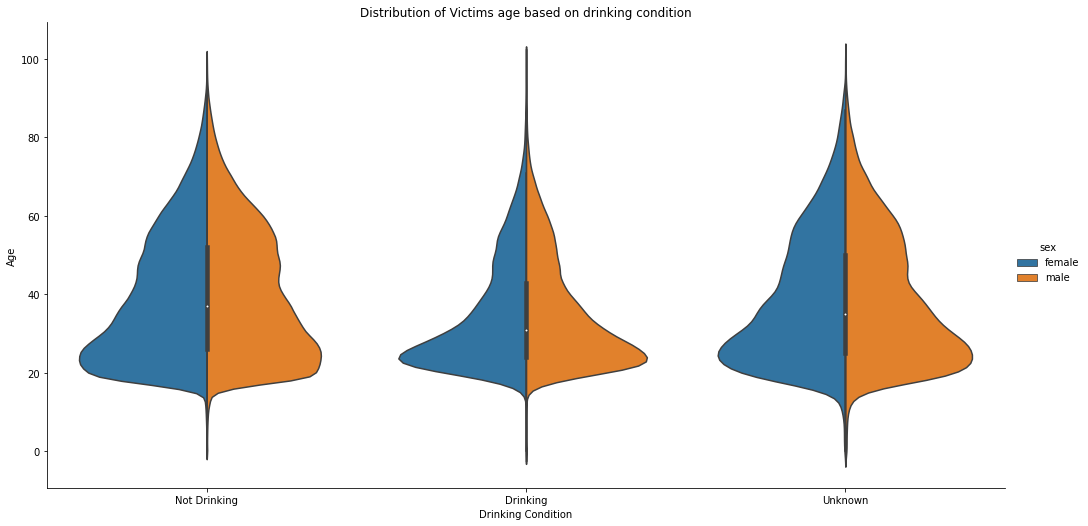

In [ ]:
ax = sns.catplot(x="party_sobriety", y="age",  kind="violin", hue = 'sex',data=df_parties, height=7, aspect=2,split=True)
plt.title('Distribution of Victims age based on drinking condition')
ax.set(xlabel="Drinking Condition", ylabel = "Age")

In [ ]:
df_collisions.dtypes

case_id                object
jurisdiction            int64
officer_id             object
reporting_district     object
chp_shift              object
                       ...   
latitude              float64
longitude             float64
collision_date         object
collision_time         object
process_date           object
Length: 74, dtype: object

In [ ]:
df_collisions['collision_severity'].dtypes

dtype('O')

In [ ]:
df_collisions['collision_date']= pd.to_datetime(df_collisions['collision_date'])
df_collisions['collision_time']= pd.to_datetime(df_collisions['collision_time'])

In [ ]:
# Identify the weekday in the time
df_collisions['weekday'] = df_collisions['collision_date'].apply(lambda s: s.weekday()) 

# Extract the hour in the time
df_collisions['hour'] = df_collisions['collision_time'].apply(lambda s: s.hour)

# Extract the month in the time
df_collisions['month'] = df_collisions['collision_date'].dt.month

# Extract the date in the time
df_collisions['day'] = df_collisions['collision_date'].apply(lambda s:str(s)[:10])

In [ ]:
# Change the week_day id to weekday names
week_days = {6:'Sunday',0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday'}
df_collisions['weekday_name'] = df_collisions['weekday'].map(week_days)

In [ ]:
df_collisions.head()

,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,state_route,route_suffix,postmile_prefix,postmile,location_type,ramp_intersection,side_of_highway,tow_away,collision_severity,killed_victims,injured_victims,party_count,primary_collision_factor,pcf_violation_code,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date,weekday,hour,month,day,weekday_name
0,6698645,1900,533363,2607,5,6,1950,0,0,not chp,None,not chp,264T1,RT 138,AVENUE R,0.0,None,1.0,clear,None,1.0,LA,7.0,138.0,None,None,48.98,highway,NaN,eastbound,1.0,property damage only,0,0,2,vehicle code violation,None,dui,23152.0,A,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,None,dark with street lights,functioning,0,NaN,NaN,NaN,NaN,1,1.0,passenger car,01,0,0,0,0,0,0,0,0,0,None,None,34.57264,-118.04491,2018-09-30,2021-05-04 19:45:00,2019-01-03,6,19.0,9,2018-09-30,Sunday
1,8008494,710,1745,None,5,5,0710,0,0,not chp,None,not chp,008,BLUME DR,RICHMOND PKWY,0.0,None,1.0,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,NaN,None,1.0,other injury,0,1,2,vehicle code violation,None,automobile right of way,21453.0,C,not hit and run,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,functioning,0,NaN,NaN,NaN,NaN,1,NaN,other bus,11,0,1,0,0,0,0,0,0,0,None,None,37.98705,-122.31694,2018-09-05,2021-05-04 11:30:00,2019-05-20,2,11.0,9,2018-09-05,Wednesday
2,8008518,1507,271,9,5,3,1507,0,0,not chp,None,not chp,None,N BEECH AV,FRESNO AV,0.0,None,1.0,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,NaN,None,0.0,property damage only,0,0,2,vehicle code violation,None,automobile right of way,21801.0,A,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,functioning,0,NaN,NaN,NaN,NaN,1,NaN,passenger car,01,0,0,0,0,0,0,0,0,0,None,None,35.51429,-119.26035,2019-08-26,2021-05-04 14:03:00,2019-09-20,0,14.0,8,2019-08-26,Monday
3,8008698,4203,23133,None,5,5,4203,0,0,not chp,None,not chp,003,SANTA BARBARA ST,PADRE ST,113.0,north,0.0,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,NaN,None,0.0,other injury,0,1,2,vehicle code violation,None,pedestrian violation,21956.0,A,not hit and run,pedestrian,pedestrian,in road,dry,normal,None,dark with no street lights,none,0,1.0,NaN,NaN,NaN,1,1.0,pedestrian,60,0,1,0,0,1,0,0,0,0,None,None,34.43413,-119.71406,2018-01-01,2021-05-04 00:59:00,2018-03-15,0,0.0,1,2018-01-01,Monday
4,80961968,1502,1177,None,5,6,1502,0,0,not chp,None,not chp,Metro,UNION AV,ALPINE ST,780.0,north,0.0,clear,None,1.0,None,NaN,NaN,None,None,NaN,None,NaN,None,1.0,other injury,0,1,1,vehicle code violation,None,dui,23152.0,A,not hit and run,hit object,fixed object,no pedestrian involved,dry,normal,None,dusk or dawn,none,0,NaN,NaN,NaN,NaN,1,1.0,passenger car,01,0,1,0,0,0,0,0,0,0,None,None,35.37000,-119.00250,2019-03-17,2021-05-04 06:28:00,2019-04-05,6,6.0,3,2019-03-17,Sunday


In [ ]:
Week_hour = df_collisions.groupby(['hour','weekday_name','day'],sort=True)['case_id'].count().reset_index()
Week_hour_avg = Week_hour.groupby(['hour','weekday_name'],sort=True)['case_id'].mean().reset_index()
# df.rename(columns = {'case_id':'count'})
# Week_hour_avg

In [ ]:
Week_hour_avg.head(10)

,hour,weekday_name,case_id
0,0.0,Friday,14.445205
1,0.0,Monday,14.204082
2,0.0,Saturday,22.424658
3,0.0,Sunday,25.068493
4,0.0,Thursday,13.374150
5,0.0,Tuesday,10.884354
6,0.0,Wednesday,12.306122
7,1.0,Friday,11.698630
8,1.0,Monday,11.789116
9,1.0,Saturday,22.517241


Text(0.5, 0.98, 'Average Collision Count by Hour Each Weekday')

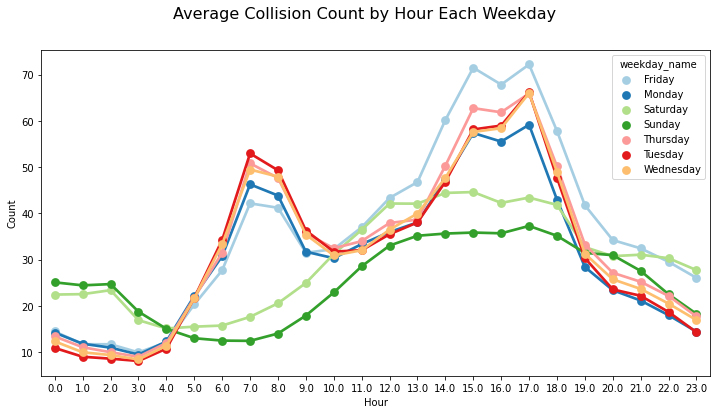

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
pal = sns.color_palette("Paired")

# Scatter plot two columns
sns.pointplot(
    x = 'hour', 
    y = 'case_id',
    hue = 'weekday_name',
    data = Week_hour_avg,
    palette = pal,
    join=True)

# Format
ax.set_xlabel("Hour")
ax.set_ylabel("Count")
fig.suptitle("Average Collision Count by Hour Each Weekday", fontsize = 16)
# ax.grid(True)

The diagram above shows the average collision counts by hour for each weekday. On workday, most of the collisions happened in morning and evening rush hour. On weekend, it shows quite different trend since people travel not for work for recreation instead. Most of them happened in afternoon and midnight.

Then we plot the collisions change to take a look at the traffic safety level  over the 15 years .

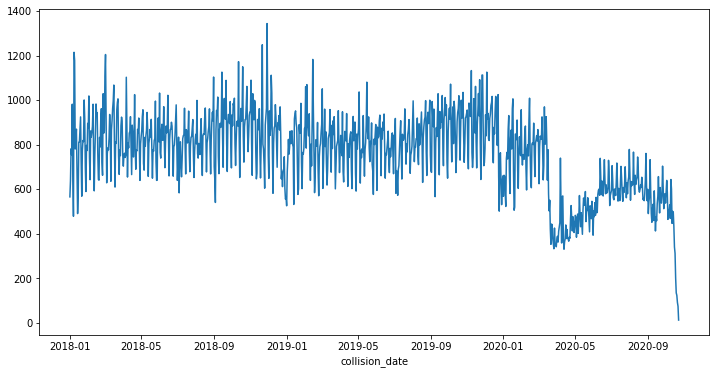

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

count_date = df_collisions.groupby('collision_date').count()['case_id']
sns.lineplot(x = count_date.index, y=count_date.values, ax=ax)
plt.show()

We want to see is there dramatic change before and after covid-19, so we zoom in to this period. There is a significant drop in March, 2020.

In [ ]:
df_collisions_covid = df_collisions.loc[(df_collisions['day'] >= "2019-01-01") & (df_collisions['day'] <= "2020-10-01")]

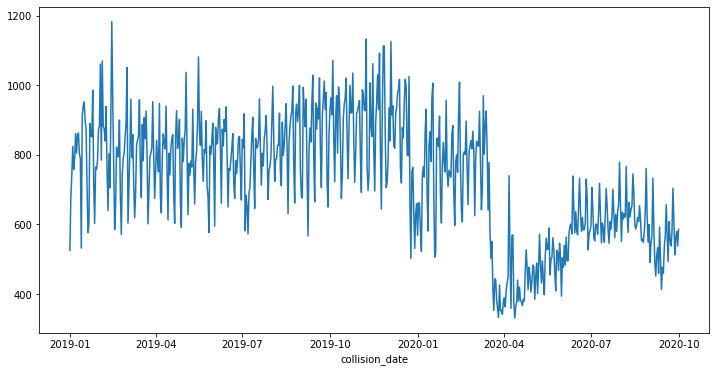

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

count_date = df_collisions_covid.groupby('collision_date').count()['case_id']
sns.lineplot(x = count_date.index, y=count_date.values, ax=ax)
plt.show()

In [ ]:
df_collisions_covid['collision_severity'].unique()
# df_collisions_covid['pcf_violation_category'].unique()

array(['property damage only', 'other injury', 'pain', 'severe injury',
       'fatal', None, 'M'], dtype=object)

Then we map out the location of collisions by severity. The collisions with sever injury and death, most of them happened in the urban area.

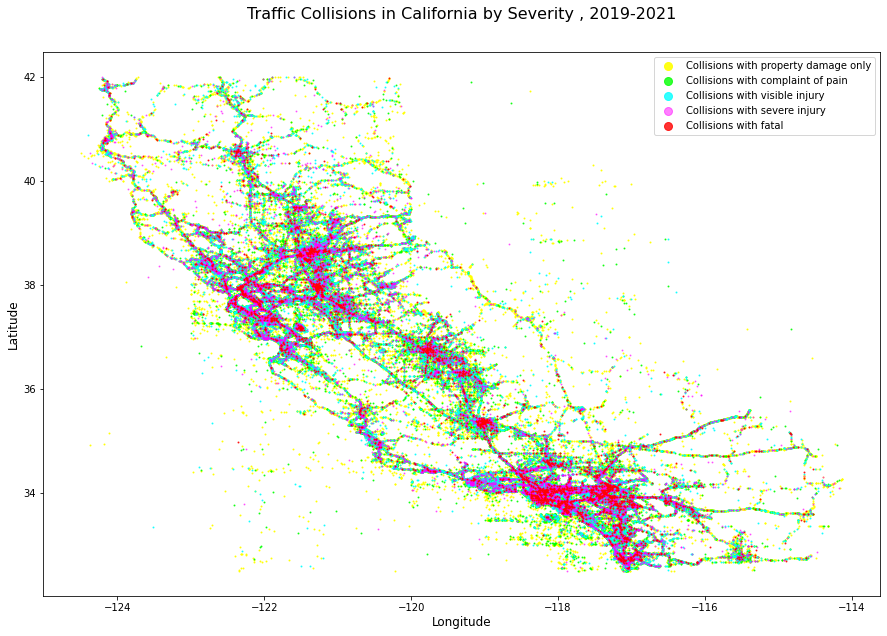

In [ ]:
df_fatal = df_collisions_covid[df_collisions_covid['collision_severity']=='fatal']
df_injury_severe = df_collisions_covid[df_collisions_covid['collision_severity']=='severe injury']
df_injury_visible = df_collisions_covid[df_collisions_covid['collision_severity']=='other injury']
df_injury_pain = df_collisions_covid[df_collisions_covid['collision_severity']=='pain']
df_property_damage = df_collisions_covid[df_collisions_covid['collision_severity']=='property damage only']

plt.figure(figsize=(15,10))

plt.plot( 'longitude', 'latitude', data=df_property_damage, linestyle='', marker='o', markersize=1, color="yellow", alpha=0.9, label='Collisions with property damage only')
plt.plot( 'longitude', 'latitude', data=df_injury_pain, linestyle='', marker='o', markersize=1, color="lime", alpha=0.8, label='Collisions with complaint of pain')
plt.plot( 'longitude', 'latitude', data=df_injury_visible, linestyle='', marker='o', markersize=1, color="aqua", alpha=0.8, label='Collisions with visible injury')
plt.plot( 'longitude', 'latitude', data=df_injury_severe, linestyle='', marker='o', markersize=1, color="fuchsia", alpha=0.5, label='Collisions with severe injury')
plt.plot( 'longitude', 'latitude', data=df_fatal, linestyle='', marker='o', markersize=1, color="red", alpha=0.8, label='Collisions with fatal')

plt.legend(markerscale=8)
plt.xlabel('Longitude', size=12, labelpad=3)
plt.ylabel('Latitude', size=12, labelpad=3)
plt.title('Traffic Collisions in California by Severity , 2019-2021', size=16, y=1.05)
plt.show()

In [ ]:
df_severity_factor = df_collisions_covid.groupby(['pcf_violation_category','collision_severity'],sort=True)['case_id'].count().reset_index()
df_severity_factor = df_severity_factor.rename(columns = {'case_id':'count'})
df_severity_factor = df_severity_factor.drop(df_severity_factor[df_severity_factor['collision_severity']=='M'].index)

In [ ]:
df_severity_factor['log_count'] = np.log(df_severity_factor['count'])

In [ ]:
df_severity_factor.groupby(['collision_severity']).sum()

,count,log_count
collision_severity,,
fatal,3731,72.992674
other injury,53705,131.418694
pain,95113,137.493896
property damage only,298465,159.830301
severe injury,15684,105.878683


In [ ]:
df_severity_factor.loc[df_severity_factor['collision_severity']=='fatal', 'pct_violation'] = df_severity_factor['count'] * 100 / 3731
df_severity_factor.loc[df_severity_factor['collision_severity']=='other injury', 'pct_violation'] = df_severity_factor['count'] * 100 / 53705
df_severity_factor.loc[df_severity_factor['collision_severity']=='pain', 'pct_violation'] = df_severity_factor['count'] * 100 / 95113	
df_severity_factor.loc[df_severity_factor['collision_severity']=='property damage only', 'pct_violation'] = df_severity_factor['count'] * 100 / 298465	
df_severity_factor.loc[df_severity_factor['collision_severity']=='severe injury', 'pct_violation'] = df_severity_factor['count'] * 100 / 15684

In [ ]:
df_severity_factor

,pcf_violation_category,collision_severity,count,log_count,pct_violation
0,automobile right of way,fatal,201,5.303305,5.387296
1,automobile right of way,other injury,6093,8.714896,11.345312
2,automobile right of way,pain,10518,9.260843,11.058425
3,automobile right of way,property damage only,16102,9.686699,5.394937
4,automobile right of way,severe injury,1216,7.103322,7.753124
...,...,...,...,...,...
100,wrong side of road,fatal,211,5.351858,5.655320
101,wrong side of road,other injury,1409,7.250636,2.623592
102,wrong side of road,pain,1429,7.264730,1.502423
103,wrong side of road,property damage only,3371,8.122965,1.129446


To explore the factors behind the collisions, we plot the violation type by collision severity.

Text(0.5, 0.98, 'Collision Severity and Factors Behind it')

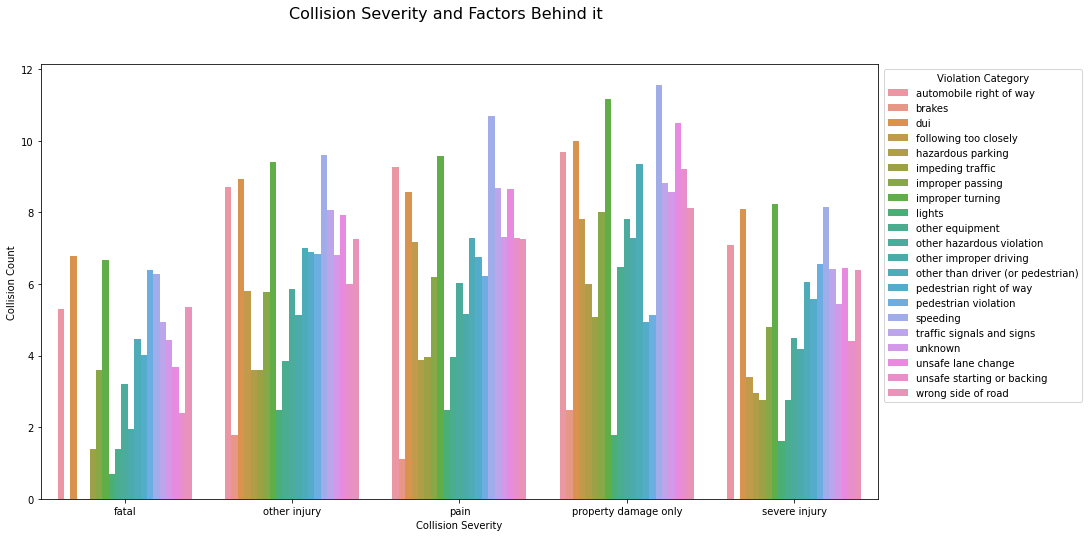

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
pal = sns.color_palette("Paired")

# Plot
sns.barplot(
    data=df_severity_factor, 
    x="collision_severity", 
    y="log_count", 
    hue="pcf_violation_category",
    # palette = pal,
    ax=ax
)

# Format
ax.set_xlabel("Collision Severity")
ax.set_ylabel("Collision Count")
ax.legend(title='Violation Category', loc='upper right', bbox_to_anchor=(1.25, 1))
fig.suptitle("Collision Severity and Factors Behind it", fontsize = 16)

Text(0.5, 0.98, 'Collision Severity and Factors Behind it')

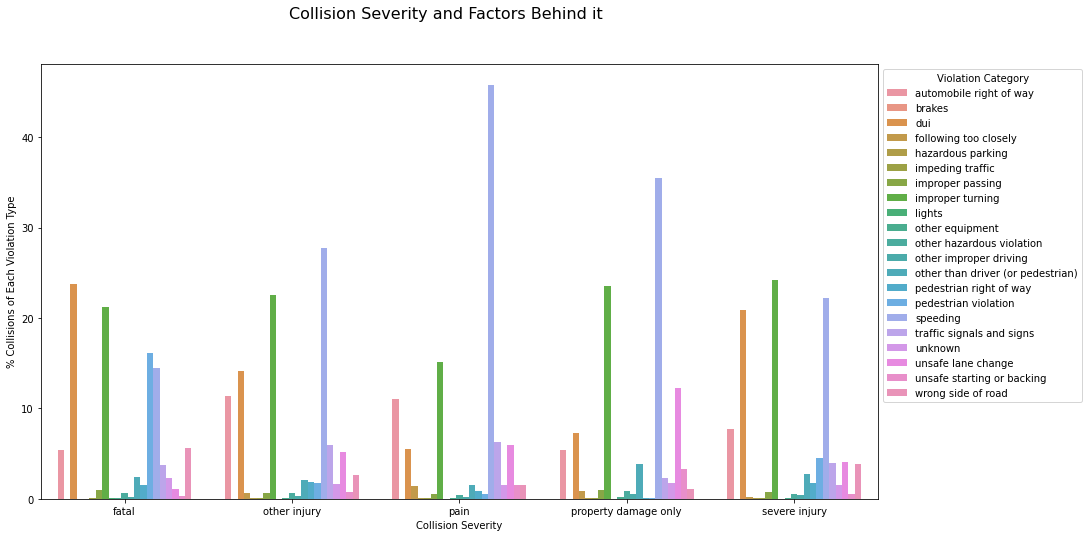

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
pal = sns.color_palette("Paired")

# Plot
sns.barplot(
    data=df_severity_factor, 
    x="collision_severity", 
    y="pct_violation", 
    hue="pcf_violation_category",
    # palette = pal,
    ax=ax
)

# Format
ax.set_xlabel("Collision Severity")
ax.set_ylabel("% Collisions of Each Violation Type")
ax.legend(title='Violation Category', loc='upper right', bbox_to_anchor=(1.25, 1))
fig.suptitle("Collision Severity and Factors Behind it", fontsize = 16)

# Modeling

## Feature Engineering

First we need to join the table together. The finish_table is the table we need in modeling.

In [ ]:
import pandasql as ps 
clean_collisions = df_collisions[["case_id", "weather_1","road_surface","lighting"]]
query = '''SELECT case_id, weather_1 as weather, road_surface as surface, lighting FROM clean_collisions where case_id>8000000 and case_id < 9200000'''
sql_collisions_df = ps.sqldf(query,locals())

In [ ]:
query1 = '''SELECT a.*,weather, surface, lighting FROM df_victims a JOIN sql_collisions_df b on a.case_id = b.case_id'''
part = ps.sqldf(query1,locals())

For the final table to use in modeling, we limit  the number of row to 10000 so that the model can run fast.

In [ ]:
query2 = '''SELECT a.*,party_sobriety,party_drug_physical FROM part a JOIN df_parties b on a.case_id = b.case_id and a.party_number = b.party_number LIMIT 10000'''
finish_table = ps.sqldf(query2,locals())
finish_table

,case_id,party_number,victim_role,age,sex,injury,seating_position,safety_equipment,weather,surface,lighting,party_sobriety,party_drug_physical
0,8404751,2,3,64.0,male,killed,9,None,clear,dry,daylight,None,Have drug or physical problem
1,8404753,2,3,38.0,female,killed,9,None,cloudy,dry,dark with no street lights,Drinking,None
2,8404754,2,3,78.0,male,killed,9,None,clear,dry,dark with street lights not functioning,Not Drinking,None
3,8404755,1,1,50.0,male,killed,1,Use Safety Equipment,clear,dry,daylight,None,Have drug or physical problem
4,8404755,2,2,22.0,female,no injury,3,Not Use Safety Equipment,clear,dry,daylight,Not Drinking,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8588986,1,1,16.0,female,minor injury,1,Use Safety Equipment,clear,dry,daylight,Unknown,Unknown
9996,8588989,1,1,55.0,female,minor injury,1,Not Use Safety Equipment,clear,dry,daylight,Not Drinking,None
9997,8588992,1,2,37.0,female,no injury,1,Not Use Safety Equipment,clear,dry,daylight,Not Drinking,None
9998,8588994,2,2,71.0,male,minor injury,3,Not Use Safety Equipment,clear,dry,daylight,Not Drinking,None


We need to change the label into integer.

In [ ]:
dict_mode = {'killed':1,'severe injury':2,'minor injury':3, 'no injury':4}
finish_table=finish_table.replace({"injury": dict_mode}) 

In [ ]:
finish_table.head()

,case_id,party_number,victim_role,age,sex,injury,seating_position,safety_equipment,weather,surface,lighting,party_sobriety,party_drug_physical
0,8404751,2,3,64.0,male,1,9,None,clear,dry,daylight,None,Have drug or physical problem
1,8404753,2,3,38.0,female,1,9,None,cloudy,dry,dark with no street lights,Drinking,None
2,8404754,2,3,78.0,male,1,9,None,clear,dry,dark with street lights not functioning,Not Drinking,None
3,8404755,1,1,50.0,male,1,1,Use Safety Equipment,clear,dry,daylight,None,Have drug or physical problem
4,8404755,2,2,22.0,female,4,3,Not Use Safety Equipment,clear,dry,daylight,Not Drinking,None


We will apply one-hot-encoding to all of the features.

In [ ]:
finish_table.age = finish_table.age.astype('float32')
finish_table.sex = finish_table.sex.astype('category')
finish_table.victim_role = finish_table.victim_role.astype('category')
finish_table.seating_position = finish_table.seating_position.astype('category')
finish_table.safety_equipment = finish_table.safety_equipment.astype('category')
finish_table.weather = finish_table.weather.astype('category')
finish_table.surface= finish_table.surface.astype('category')
finish_table.lighting= finish_table.lighting.astype('category')
finish_table.party_sobriety = finish_table.party_sobriety.astype('category')
finish_table.party_drug_physical = finish_table.party_drug_physical.astype('category')
finish_table.injury = finish_table.injury.astype('category')

In [ ]:
finish_table=finish_table.drop(columns=['case_id', 'party_number'])

In [ ]:
feature_df = pd.get_dummies(finish_table, prefix=['victim_role','age','sex','seating_position','safety_equipment','weather','surface','lighting','party_sobriety','party_drug_physical'], 
                            columns=['victim_role','age','sex','seating_position','safety_equipment','weather','surface','lighting','party_sobriety','party_drug_physical'])

The dataset is splitted into features and label, then splitted into the train set (80%) and test set (20%).

In [ ]:
from sklearn.model_selection import train_test_split
labeld = feature_df['injury']
featuresd = feature_df.loc[:, feature_df.columns != 'injury']
x_train, x_test, y_train, y_test = train_test_split(featuresd,labeld,test_size=0.2)

In [ ]:
x_train.shape

(8000, 140)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
feature_df.to_csv( "/content/545_dat.csv", index=False, encoding='utf-8-sig')

## Logistic regression

First, we use logistic regression.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix,plot_confusion_matrix

clf = LogisticRegression(max_iter=100)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
mse_test = mean_squared_error(y_test, y_pred)
print("mse of logistic regression is: ", mse_test)

mse of logistic regression is:  0.2845


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
from sklearn.metrics import accuracy_score
acc_test = accuracy_score(y_test, y_pred)
print("accuracy score is: ", acc_test)

accuracy score is:  0.816


Evaluate the model using confusion matrix.

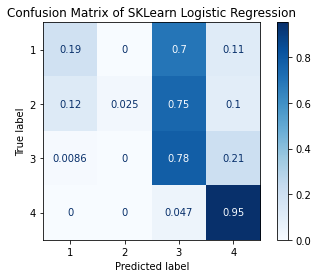

In [ ]:
disp = plot_confusion_matrix(clf, x_test, y_test,cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('Confusion Matrix of SKLearn Logistic Regression')

plt.show()

In [ ]:
coef_df = pd.DataFrame(clf.coef_,columns=x_train.columns,
                       index=['killed','severe injury','minor injury', 'no injury'])
coef_df

,victim_role_1,victim_role_2,victim_role_3,victim_role_4,victim_role_5,age_0.0,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,age_8.0,age_9.0,age_10.0,age_11.0,age_12.0,age_13.0,age_14.0,age_15.0,age_16.0,age_17.0,age_18.0,age_19.0,age_20.0,age_21.0,age_22.0,age_23.0,age_24.0,age_25.0,age_26.0,age_27.0,age_28.0,age_29.0,age_30.0,age_31.0,age_32.0,age_33.0,age_34.0,...,age_95.0,age_96.0,age_97.0,age_98.0,sex_female,sex_male,seating_position_0,seating_position_1,seating_position_2,seating_position_3,seating_position_4,seating_position_5,seating_position_6,seating_position_7,seating_position_8,seating_position_9,safety_equipment_None in Vechicle,safety_equipment_Not Use Safety Equipment,safety_equipment_Unknown,safety_equipment_Use Safety Equipment,weather_clear,weather_cloudy,weather_fog,weather_other,weather_raining,weather_wind,surface_dry,surface_slippery,surface_snowy,surface_wet,lighting_dark with no street lights,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,party_sobriety_Drinking,party_sobriety_Not Drinking,party_sobriety_Unknown,party_drug_physical_Have drug or physical problem,party_drug_physical_Unknown
killed,0.142714,-1.545252,0.913596,0.395475,-0.149773,-0.102645,-0.203693,0.185794,-0.540549,-0.129125,-0.400760,-0.436353,-0.646783,0.297106,-0.270554,-0.436035,-0.393555,-0.890420,0.500412,-0.101490,-0.963193,-0.758304,0.012201,-0.299961,0.341497,-0.306098,-0.545045,0.029818,-0.993551,0.357365,0.080975,-0.118765,-0.435954,0.075992,0.610867,0.109000,0.426795,-0.254050,0.410034,0.541433,...,0.129740,-0.000402,-0.006066,-0.000402,-0.145741,-0.097498,-1.110885,0.188351,0.540318,0.000521,0.064630,-0.096540,0.372305,-0.093046,-0.047726,-0.061170,-0.128391,-0.529536,-0.319083,0.225760,0.659882,0.505656,-0.357379,-0.151866,-0.316759,0.0,0.199428,-0.131060,-0.004955,0.495688,0.750862,-0.038710,0.626822,-0.503353,-0.132331,0.557522,-0.889391,0.605549,1.662029,0.605549
severe injury,0.625533,-1.338723,0.694020,0.229042,-0.182157,-0.165170,-0.331768,0.472811,0.143209,0.076425,0.029533,0.130607,0.087349,0.084109,0.238644,-0.404305,0.393598,0.227923,-0.253535,-0.664864,0.283488,-0.665162,-0.537514,-0.054528,-0.551916,-0.500964,-0.440814,-0.311415,0.333247,-0.039671,0.209009,0.344885,-0.382993,-0.462701,-0.785852,0.197423,0.072050,0.578742,-0.131322,0.205061,...,-0.071592,-0.000548,-0.003967,-0.000548,-0.090810,0.118526,-0.052586,0.137919,0.283275,-0.451393,-0.267851,0.265849,-0.005480,-0.283449,0.575606,-0.174173,-0.161056,-0.677744,0.759753,0.524771,-0.491837,-0.010767,-0.468062,-0.346129,0.618170,0.0,0.495435,-0.063020,-0.086816,-0.491266,-0.476476,0.029491,-0.156966,-0.218169,-0.122834,0.026715,-0.254132,0.095716,-0.495371,0.095716
minor injury,0.991665,-0.949714,-0.158359,0.261956,0.357585,-0.000369,-0.443523,-1.000415,0.016733,-0.310778,-0.131263,0.217900,0.169126,-0.228307,-0.099941,0.467943,-0.209313,0.424137,0.127384,0.474822,0.340715,0.941230,0.414055,0.330247,0.184344,0.473295,0.202165,-0.028882,0.585079,0.049137,0.084703,0.108782,0.431678,0.191385,-0.022960,-0.066057,-0.217506,0.002265,-0.083052,-0.238647,...,-0.206025,-0.154092,0.578929,-0.154092,0.423573,0.079562,0.535344,0.406545,-0.153257,0.321996,0.139740,-0.081902,-0.082454,0.141492,-1.110236,0.385867,0.292352,0.414139,-0.118434,-0.069591,-0.048463,-0.108539,0.668452,0.329196,-0.169985,0.0,-0.479381,0.612288,-0.070630,-0.208291,-0.091531,0.061418,-0.089275,0.306959,0.192577,-0.467292,0.425971,-0.450831,-1.182777,-0.450831
no injury,-1.759913,3.833688,-1.449258,-0.886474,-0.025655,0.268183,0.978984,0.341810,0.380607,0.363477,0.502490,0.087846,0.390307,-0.152908,0.131851,0.372397,0.209269,0.238360,-0.374261,0.291532,0.338989,0.482237,0.111257,0.024242,0.026076,0.333766,0.783694,0.310479,0.075225,-0.366832,-0.374687,-0.334903,0.387269,0.195324,0.197946,-0.240366,-0.281339,-0.326956,-0.195660,-0.507847,...,0.147877,0.155042,-0.568896,0.155042,-0.187022,-0.100589,0.628127,-0.732816,-0.

## Random Forest Classifier
We focus on building better classifiers and used grid search to find an optimal combination of estimators and max depths.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(n_estimators = 5, max_depth=5)

# use grid search and train a random forest model on the transformed train dataset.
param_grid = { 
    'n_estimators': [8,10,100],
    'max_depth': [10,20,30]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(x_train, y_train)
print(CV_rfc.best_params_)

{'max_depth': 20, 'n_estimators': 100}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

rfc = RandomForestClassifier(n_estimators = 100, max_depth=20)
rfc.fit(x_train,y_train)

y_pred = rfc.predict(x_test)
mse_test = mean_squared_error(y_test, y_pred)
print("mse of random forest is: ", mse_test)

mse of random forest is:  0.2905


In [ ]:
from sklearn.metrics import accuracy_score
acc_test = accuracy_score(y_test, y_pred)
print("accuracy score is: ", acc_test)

accuracy score is:  0.814


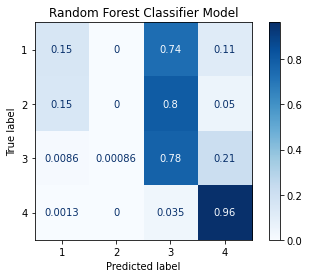

In [ ]:
disp = plot_confusion_matrix(rfc, x_test, y_test,cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('Random Forest Classifier Model')
plt.show()

## Bagging
We use bagging to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression.

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix,plot_confusion_matrix

In [ ]:
#initialize the base classifier, 100 no. of base clssifier
dtc = DecisionTreeClassifier()
bag_clf=BaggingClassifier(base_estimator=dtc, n_estimators=100, bootstrap=True)
bag_clf=bag_clf.fit(x_train,y_train)

In [ ]:
y_pred = bag_clf.predict(x_test)
mse_test = mean_squared_error(y_test, y_pred)
print("mse of bagging is: ", mse_test)
bag_score = bag_clf.score(x_test, y_test)
print("accuracy score is: ", bag_score)

mse of bagging is:  0.312
accuracy score is:  0.7945


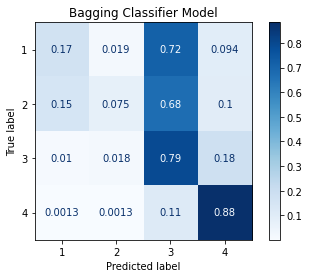

In [ ]:
display = plot_confusion_matrix(bag_clf, x_test, y_test,cmap=plt.cm.Blues, normalize='true')
display.ax_.set_title('Bagging Classifier Model')
plt.show()

## Ada-boosting


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix,plot_confusion_matrix

In [ ]:
#specify the total number of trees in the forest
aba_clf = AdaBoostClassifier(n_estimators=100, random_state=0)
aba_clf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [ ]:
y_pred = aba_clf.predict(x_test)
mse_test = mean_squared_error(y_test, y_pred)
print("mse of ada-boosting is: ", mse_test)
aba_score = aba_clf.score(x_test, y_test)
print("accuracy score is: ", aba_score)

mse of ada-boosting is:  0.856
accuracy score is:  0.391


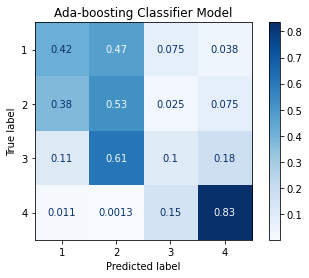

In [ ]:
display = plot_confusion_matrix(aba_clf, x_test, y_test,cmap=plt.cm.Blues, normalize='true')
display.ax_.set_title('Ada-boosting Classifier Model')
plt.show()

## Feedforward Neural Network

Next, we will use PyTorch to train a FNN model, predict

### Convert data to Tensors

Convert the data to Tensors, so that PyTorch can use the data.

In [ ]:
# feature_df = pd.read_csv("/content/545_dat.csv")

In [ ]:
# from sklearn.model_selection import train_test_split
# labeld = feature_df['injury']
# featuresd = feature_df.loc[:, feature_df.columns != 'injury']
# x_train, x_test, y_train, y_test = train_test_split(featuresd,labeld,test_size=0.2)

In [ ]:
class CreateDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [ ]:
train_dataset = CreateDataset(torch.from_numpy(np.array(x_train)).float(), torch.from_numpy(np.array(y_train)).long())
test_dataset = CreateDataset(torch.from_numpy(np.array(x_test)).float(), torch.from_numpy(np.array(y_test)).long())

### Create Data Loader

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Weighted Sampling

Define a function to create a dictionary with the frequency of each class

In [ ]:
def create_frequency_dict(y_train):
  count_dict = {
    "Killed": 0,
    "Severe_Injury": 0,
    "Other_Visible_Injury": 0,
    "Complaint_of_Pain": 0, }
  labels = np.array(y_train)
  for i in labels:
    if i == 1: 
      count_dict["Killed"] += 1
    if i == 2:
      count_dict["Severe_Injury"] += 1
    elif i == 3: 
      count_dict["Other_Visible_Injury"] += 1
    elif i == 4: 
      count_dict["Complaint_of_Pain"] += 1             
        
  return count_dict

In [ ]:
create_frequency_dict(y_train)

{'Complaint_of_Pain': 2996,
 'Killed': 193,
 'Other_Visible_Injury': 4622,
 'Severe_Injury': 189}

Calculate the weight for each class

In [ ]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

class_count = [i for i in create_frequency_dict(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0052, 0.0053, 0.0002, 0.0003])


In [ ]:
# class_weights_all = class_weights[target_list]

### Define model

Define and initialize an FNN model. The FNN model we defined has 3 hidden layers.

In [ ]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, n_features, n_labels):
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(n_features, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)       
        self.fc5 = nn.Linear(32, n_labels)  
    
    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc4(x))
      out = self.fc5(x)
      return out

In [ ]:
n_features = 140
n_labels = 5
fnn_model = FeedforwardNeuralNetModel(n_features, n_labels)

In [ ]:
fnn_input_dim = 140 
summary(fnn_model.to(device), (1, fnn_input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]          72,192
            Linear-2               [-1, 1, 128]          65,664
            Linear-3                [-1, 1, 64]           8,256
            Linear-4                [-1, 1, 32]           2,080
            Linear-5                 [-1, 1, 5]             165
Total params: 148,357
Trainable params: 148,357
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.57
Estimated Total Size (MB): 0.57
----------------------------------------------------------------


Define loss function.

In [ ]:
criterion = nn.CrossEntropyLoss()

Define learning rate and optimizer.

In [ ]:
learning_rate = 0.0001
fnn_optimizer = torch.optim.Adam(fnn_model.parameters(), lr=learning_rate)

### Train Model

Define a function to train the model.

In [ ]:
def train_model(model, optimizer, criterion, epochs=10):
    for child in model.children():
      if hasattr(child, 'reset_parameters'):
        child.reset_parameters()
    model.train()
    model.to(device)

    loss_list = []
    accuracy_list = []
    for epoch in range(int(epochs)):
      correct = 0
      total = 0
      running_loss = 0.0
      for x_train_batch, y_train_batch in train_loader:
        x_train_batch, y_train_batch = x_train_batch.to(device), y_train_batch.to(device)
        # Clear gradients parameters
        optimizer.zero_grad()
        # Forward pass to get output
        outputs = model(x_train_batch)
        # Compute the loss
        loss = criterion(outputs, y_train_batch)
        # Compute the gradients for each of the model parameters
        loss.backward()
        # Use the optimizer to update the weights
        optimizer.step()

        # Calculate the accuracy
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        # Total number of labels
        total += y_train_batch.size(0)
        # Total correct predictions
        correct += (predicted == y_train_batch).sum().item()
        
        # Calculate the loss
        running_loss += loss.item()
      
      loss = running_loss / len(train_loader)
      accuracy = correct / total
      accuracy_list.append(accuracy)
      loss_list.append(loss)
      print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss, accuracy))
    print(loss_list)
    print(accuracy_list)
    
    final_training_accuracy = accuracy_list[-1]
    final_training_loss = loss_list[-1]
    return final_training_loss, final_training_accuracy, loss_list, accuracy_list

Train the FNN model using the train_model function defined above.

In [ ]:
fnn_epochs = 15 
fnn_training_loss, fnn_training_accuracy, loss_list, accuracy_list = train_model(fnn_model, fnn_optimizer, criterion, fnn_epochs)

print("Feedforward Neural Network - the training loss is ", str(fnn_training_loss))
print("Feedforward Neural Network - the training accuracy is ", str(fnn_training_accuracy))

Epoch: 0. Loss: 0.5119158362741583. Accuracy: 0.80425
Epoch: 1. Loss: 0.4332592050987587. Accuracy: 0.829875
Epoch: 2. Loss: 0.4226778775337443. Accuracy: 0.832875
Epoch: 3. Loss: 0.4132651563011241. Accuracy: 0.834625
Epoch: 4. Loss: 0.40846511714512235. Accuracy: 0.839375
Epoch: 5. Loss: 0.40178796073505785. Accuracy: 0.83975
Epoch: 6. Loss: 0.3935961569063693. Accuracy: 0.845625
Epoch: 7. Loss: 0.3859417682365656. Accuracy: 0.852
Epoch: 8. Loss: 0.37992942120699624. Accuracy: 0.853375
Epoch: 9. Loss: 0.37094535900919207. Accuracy: 0.85475
Epoch: 10. Loss: 0.3621376637089088. Accuracy: 0.858625
Epoch: 11. Loss: 0.3534745948508912. Accuracy: 0.859125
Epoch: 12. Loss: 0.3431563534468088. Accuracy: 0.865875
Epoch: 13. Loss: 0.33096236643540977. Accuracy: 0.8675
Epoch: 14. Loss: 0.321811864092064. Accuracy: 0.873125
[0.5119158362741583, 0.4332592050987587, 0.4226778775337443, 0.4132651563011241, 0.40846511714512235, 0.40178796073505785, 0.3935961569063693, 0.3859417682365656, 0.379929421

Plot the accuracy and loss

In [ ]:
from matplotlib import pyplot as plt
epoch_list=list()
for i in range(1, 16):
  epoch_list.append(i)

Text(0, 0.5, 'Loss')

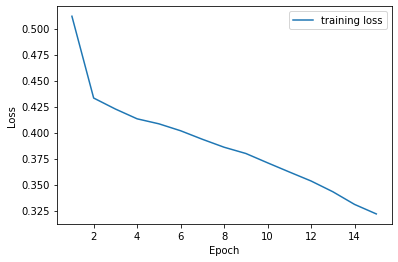

In [ ]:
plt.plot(epoch_list, loss_list, label='training loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

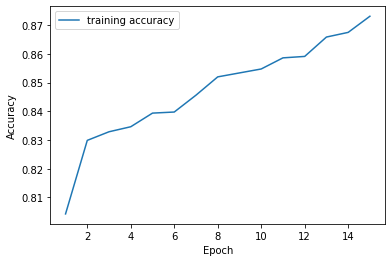

In [ ]:
plt.plot(epoch_list, accuracy_list, label='training accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

### Evaluate Model


Define a function to evaluate the model

In [ ]:
def test_model(model, criterion):
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0
    for x_test_batch, y_test_batch in train_loader:
      x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)
      outputs = model(x_test_batch)

      loss = criterion(outputs, y_test_batch)

      _, predicted = torch.max(outputs.data, 1)
      total += y_test_batch.size(0)
      correct += (predicted == y_test_batch).sum().item()

      running_loss += loss.item()

    testing_accuracy =  correct / total
    testing_loss = running_loss / len(test_loader)

    return  testing_loss, testing_accuracy

In [ ]:
fnn_testing_loss, fnn_testing_accuracy = test_model(fnn_model, criterion)

print("Feedforward Neural Network - the testing loss is ", str(fnn_testing_loss))
print("Feedforward Neural Network - the testing accuracy is ", str(fnn_testing_accuracy))

Feedforward Neural Network - the testing loss is  1.2104630659704776
Feedforward Neural Network - the testing accuracy is  0.87875


The accuracy of FNN model is 0.879, the accuracy is significantly improved compared to the logistic regression model.

# Conclusion

We saw that the collision reduced in 2020 in contrast to previous 2 years.These may caused by the pandamic.

From our model, we saw that people who are drinking and using drug are more vulnerable and more likely to be killed in the collision. So we need to avoid these behaviors during the trip.